In [1]:
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import seaborn as sns

# Only one scan was dealt with in this script. More to follow soon

MORE INFORMATION on importing .dcm files: https://www.kaggle.com/srikanthpotukuchi/understanding-dcm-files-using-pydicom

In [12]:
# try importing the dcm file
ds = pydicom.dcmread('1.dcm')
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.12297650151329871895440507938349160734
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'
(0008, 1090) Manufacturer's Model Name           LO: 'LightSpeed VCT'
(0010, 0010) Patient's Name                      PN: 'ID00007637202177411956430'
(0010, 0020) Patient ID                          LO: 'ID00007637202177411956430'
(0010, 0040) Patient's Sex                       CS: ''
(0012, 0063) De-identification Method            LO: 'Table;'
(0018, 0015) Body Part Examined                  CS: 'Chest'
(0018, 0050) Slice Thickness                     DS: "1.25"
(0018, 0060) KVP                                 DS: "120.0"
(0018, 1110) Distance Source to Detector         DS: "949.075012"
(0018, 1111) Distance

In [13]:
# some basic info
# Credits: https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom.html#sphx-glr-auto-examples-input-output-plot-read-dicom-py
if 'PixelData' in ds:
    rows = int(ds.Rows)
    cols = int(ds.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(ds.PixelData)))
    if 'PixelSpacing' in ds:
        print("Pixel spacing....:", ds.PixelSpacing)

Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: [0.652344, 0.652344]


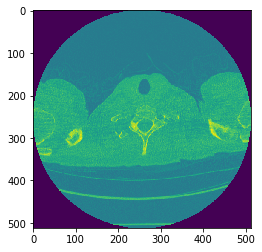

In [14]:
# visualization
plt.imshow(ds.pixel_array) 
plt.savefig('testplot.png')

In [15]:
# get the array that we care about
arr = ds.pixel_array

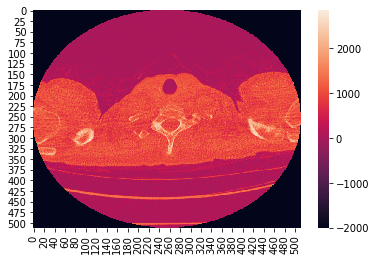

In [16]:
# plot using seaborn
sns.heatmap(arr)
plt.show()

# UNET with lungmask Toolbox -- Pre-trained Model

https://github.com/JoHof/lungmask

https://www.kaggle.com/smerllo/lung-mask-using-u-net-r231

In [88]:
from lungmask import mask
import SimpleITK as sitk
from skimage.measure import label,regionprops
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt

INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!


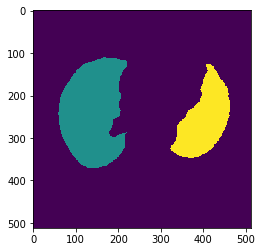

In [89]:
input_image = sitk.ReadImage('19.dcm')
segmentation = mask.apply(input_image)
plt.imshow(segmentation[0])

# Keras Example

https://keras.io/examples/vision/oxford_pets_image_segmentation/#prepare-paths-of-input-images-and-target-segmentation-masks

## More details on UNET -- still working on it

ref: 

https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

https://keras.io/examples/vision/oxford_pets_image_segmentation/

https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

In [90]:
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

In [91]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((512, 512, 1))
output_layer = build_model(input_layer, 16)

In [92]:
model = Model(input_layer, output_layer)

In [93]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [94]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 16) 2320        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (512, 512)